In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [2]:
spam_dataset = pd.read_csv('../Files/spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


##### Sprawdzamy czy nasze klasy s zbalansowane

In [3]:
print(spam_dataset['Spam'].value_counts(normalize=True))

Spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


#### Usuwanie znaków interpunkcyjnych

In [4]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


##### Zamieniamy wielkie litery na małe

In [5]:
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


##### Usuwanie stopwords

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

In [7]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


##### Stemming - usuwanie części wyrazu lub sprowadzenia wyrazu do jego rdzenia lub korzenia

In [8]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


##### Lematyzacja - np. 'better' zostanie przekształcone na 'good'

In [9]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


##### Na podstawie zlematyzowanych maili stwórzmy stringa, który jest połączeniem wszystkich słów dla maili, które są spamem oraz dla maili, które nie są spamem.

In [10]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)

words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

##### Tworzymy chmurę słów dla spamów

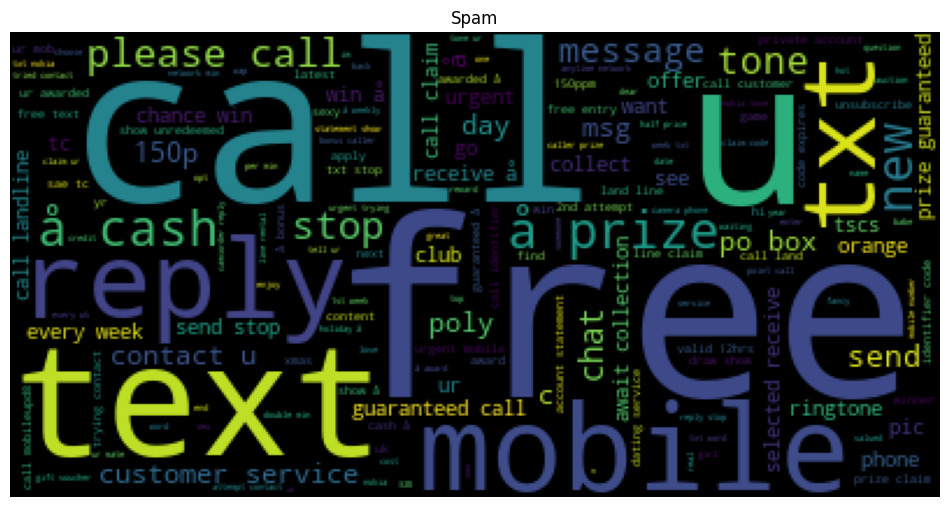

In [11]:
wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Spam')
plt.show()

##### Tworzymy chmurę dla nie-spamów

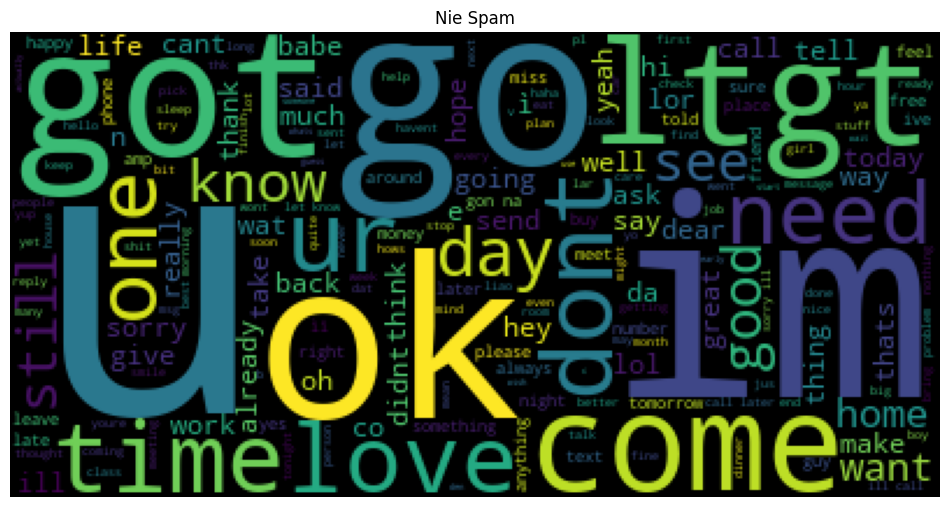

In [12]:
wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Nie Spam')
plt.show()

### Wektoryzacja TF (Częstotliwość terminów) - IDF (Odwrotność częstotliwości terminów)

In [13]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
print(X.shape)
y = spam_dataset['Spam']
print(y.shape)

(5572, 8841)
(5572,)


In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
clf.score(X, y)

0.8659368269921034

##### Inne metody wektoryzacji tekstu - wyliczanie liczby wystąpień w poszczególnych mailach

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(min_df=0.01, max_df=0.5)  # słowa, które pojawiają się rzadziej niż w 1% maila lub częściej niż w 50% maili są ignorowane
X_count = count.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
X_count

<5572x129 sparse matrix of type '<class 'numpy.int64'>'
	with 15648 stored elements in Compressed Sparse Row format>

In [16]:
clf_v2 = RandomForestClassifier(max_depth=2, random_state=0)
clf_v2.fit(X_count, y)
clf_v2.score(X_count, y)

0.8695262024407753

In [17]:
vocabulary = count.vocabulary_
word_frequencies = X_count.sum(axis=0)
# Tworzenie listy wybranych słów wraz z ich liczbami wystąpień
selected_words_with_frequencies = [(word, word_frequencies[0, idx]) for word, idx in vocabulary.items()]
# Sortowanie listy po liczbie wystąpień
selected_words_with_frequencies.sort(key=lambda x: x[1], reverse=True)
# Wyświetlenie wybranych słów wraz z ich liczbami wystąpień
for word, frequency in selected_words_with_frequencies:
    print(f"Word: {word}, Frequency: {frequency}")

Word: call, Frequency: 600
Word: im, Frequency: 462
Word: get, Frequency: 397
Word: ur, Frequency: 384
Word: go, Frequency: 304
Word: dont, Frequency: 279
Word: ok, Frequency: 277
Word: ltgt, Frequency: 276
Word: free, Frequency: 275
Word: know, Frequency: 267
Word: got, Frequency: 250
Word: come, Frequency: 247
Word: like, Frequency: 245
Word: day, Frequency: 241
Word: ill, Frequency: 237
Word: good, Frequency: 235
Word: time, Frequency: 232
Word: text, Frequency: 214
Word: want, Frequency: 213
Word: love, Frequency: 203
Word: send, Frequency: 190
Word: need, Frequency: 182
Word: one, Frequency: 180
Word: going, Frequency: 171
Word: today, Frequency: 169
Word: txt, Frequency: 163
Word: home, Frequency: 162
Word: lor, Frequency: 160
Word: see, Frequency: 157
Word: sorry, Frequency: 156
Word: still, Frequency: 153
Word: stop, Frequency: 153
Word: back, Frequency: 152
Word: mobile, Frequency: 150
Word: think, Frequency: 146
Word: reply, Frequency: 145
Word: take, Frequency: 142
Word: tel

##### Teraz sprawdźmy jak wygląda X, na podstawie którego model się uczy, jak i wykonuje prognozę. Przekształćmy go do Numpy array. Pokażmy 5 pierwszych obserwacji.

In [18]:
print(X_count.toarray()[:5])  ## model 1-gramowy

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0

# Zadanie 17_2

##### Podział danych i nauka modelu

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, stratify=y)

In [20]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8663677130044843

In [21]:
f_imp = clf.feature_importances_
important = []

for x in f_imp:
    if x > 0.001:
        important.append(x)

In [42]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average='macro')
    metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame({'Model': [name], 'F1_score': [f1_metric]})], ignore_index=True)

    return metrics_dataframe

In [43]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, stratify=y)

In [36]:
forest_v1= Pipeline(steps=[('TF-IDF', TfidfVectorizer(analyzer='word', lowercase=False)),
                           ('MODEL', RandomForestClassifier())])

In [37]:
list(forest_v1.get_params().keys())

['memory',
 'steps',
 'verbose',
 'TF-IDF',
 'MODEL',
 'TF-IDF__analyzer',
 'TF-IDF__binary',
 'TF-IDF__decode_error',
 'TF-IDF__dtype',
 'TF-IDF__encoding',
 'TF-IDF__input',
 'TF-IDF__lowercase',
 'TF-IDF__max_df',
 'TF-IDF__max_features',
 'TF-IDF__min_df',
 'TF-IDF__ngram_range',
 'TF-IDF__norm',
 'TF-IDF__preprocessor',
 'TF-IDF__smooth_idf',
 'TF-IDF__stop_words',
 'TF-IDF__strip_accents',
 'TF-IDF__sublinear_tf',
 'TF-IDF__token_pattern',
 'TF-IDF__tokenizer',
 'TF-IDF__use_idf',
 'TF-IDF__vocabulary',
 'MODEL__bootstrap',
 'MODEL__ccp_alpha',
 'MODEL__class_weight',
 'MODEL__criterion',
 'MODEL__max_depth',
 'MODEL__max_features',
 'MODEL__max_leaf_nodes',
 'MODEL__max_samples',
 'MODEL__min_impurity_decrease',
 'MODEL__min_samples_leaf',
 'MODEL__min_samples_split',
 'MODEL__min_weight_fraction_leaf',
 'MODEL__n_estimators',
 'MODEL__n_jobs',
 'MODEL__oob_score',
 'MODEL__random_state',
 'MODEL__verbose',
 'MODEL__warm_start']

In [38]:
import warnings
warnings.filterwarnings('ignore')

params = {
    'TF-IDF__max_df': [0.5, 0.7, 0.9],
    'TF-IDF__min_df': [0.0001, 0.001, 0.002],
    'TF-IDF__ngram_range': [(1,1), (2,2)],
    'MODEL__max_depth': [3, 5, 7],
    'MODEL__n_jobs': [-1, 200, 500, 1000],
    'MODEL__min_samples_leaf': [0.1, 1.0, 10],
    'MODEL__random_state': [0, 42]
}

grid_search = GridSearchCV(forest_v1, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')
# dodałem wyjątek aby zlikwidować warning
try:
    grid_search.fit(X_train, y_train)
except Exception as e:
    print("Błąd podczas grid search:", e)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v1 = grid_search.best_estimator_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Wybrane hiperparametry:  {'MODEL__max_depth': 7, 'MODEL__min_samples_leaf': 10, 'MODEL__n_jobs': -1, 'MODEL__random_state': 42, 'TF-IDF__max_df': 0.5, 'TF-IDF__min_df': 0.002, 'TF-IDF__ngram_range': (1, 1)}


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.32      0.49       149

    accuracy                           0.91      1115
   macro avg       0.95      0.66      0.72      1115
weighted avg       0.92      0.91      0.89      1115



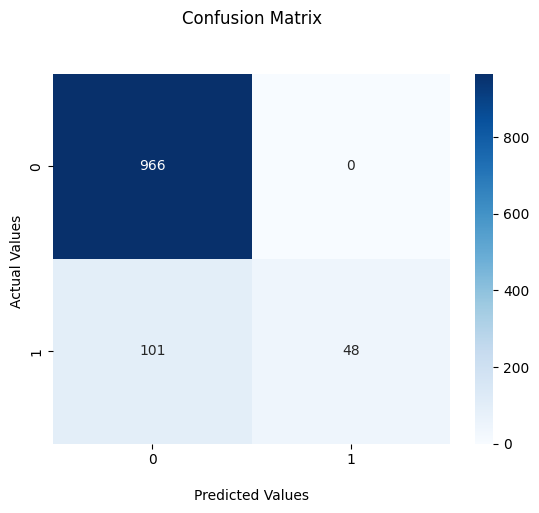

,Model,F1_score,AUC
0,Random Forest,0.718815,NaN


In [41]:
calculate_metrics(model_v1, 'Random Forest', X_test, y_test)